# Simple demo of a three, identical multi-component buildings in a multi-agent env

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gridworld import MultiAgentEnv, MultiComponentEnv
from gridworld.agents.buildings import FiveZoneROMThermalEnergyEnv
from gridworld.agents.pv import PVEnv
from gridworld.agents.energy_storage import EnergyStorageEnv
from gridworld.distribution_system import OpenDSSSolver

%matplotlib inline

[WARNING] multiagent_env.py:17: rllib MultiAgentEnv not found, using generic object class


# Env configuration

In [2]:
# Start by defining the components.
building = {
    "name": "building",
    "cls": FiveZoneROMThermalEnergyEnv,
    "config": {
        "rescale_spaces": False,
        "obs_config": {
            "zone_temp": (18, 34),
            "p_consumed": (-100, 100)
        }
    }
}

pv = {
    "name": "pv",
    "cls": PVEnv,
    "config": {
        "profile_csv": "pv_profile.csv",
        "scaling_factor": 10.,
        "rescale_spaces": False
    }
}

storage = {
    "name": "storage",
    "cls": EnergyStorageEnv,
    "config": {"rescale_spaces": False}
}

components = [building, pv, storage]


# Next, create the 3 identical agents with different names.  Note that the 
# MultiComponentEnv configuration requires a "components" key/value.
agents = [
    {
        "name": "building-{}".format(i),
        "bus": "675c",
        "cls": MultiComponentEnv,
        "config": {"components": components}
    } for i in range(3)
]


common_config = {
    "start_time": "08-12-2021 00:00:00",
    "end_time": "08-13-2021 00:00:00",
    "control_timedelta": pd.Timedelta(300, "s")
}

pf_config = {
    "cls": OpenDSSSolver,
    "config": {
        "feeder_file": "ieee_13_dss/IEEE13Nodeckt.dss",
        "loadshape_file": "ieee_13_dss/annual_hourly_load_profile.csv",
        "system_load_rescale_factor": 0.7,
    }
}

env_config = {
    "common_config": common_config,
    "pf_config": pf_config,
    "agents": agents
}

env = MultiAgentEnv(**env_config)

In [3]:
env.reset()
done = {"__all__": False}
metas = []
states = []
while not done["__all__"]:
    action = {name: space.sample() for name, space in env.action_space.items()}
    obs, rew, done, meta = env.step(action)
    states.append(obs)
    metas.append(meta)

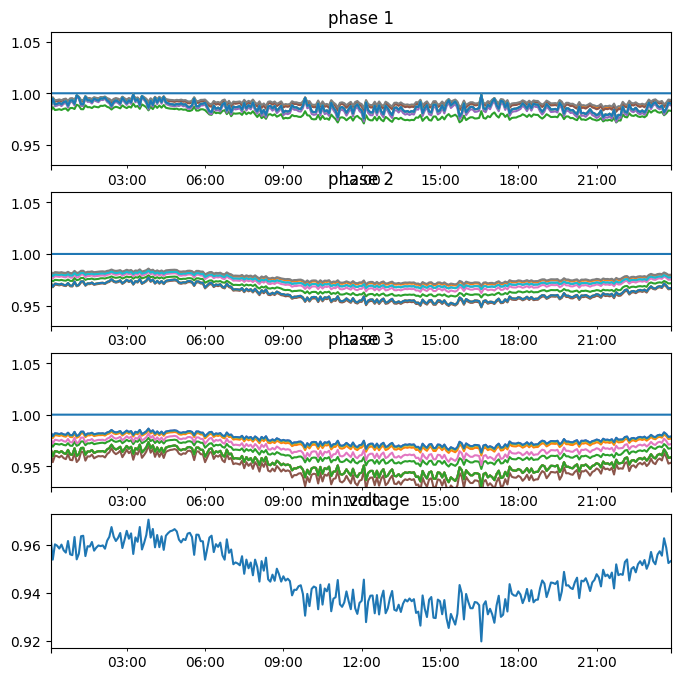

In [4]:
df = pd.DataFrame(env.history["voltage"], index=env.history["timestamp"])

fig, ax = plt.subplots(4)
fig.set_size_inches((8, 8))
for i in range(3):
    _ = df[[x for x in df.columns if x.startswith("6") and x.endswith(str(i+1))]].plot(
        ax=ax[i], legend=False, ylim=(0.93, 1.06), title="phase " + str(i+1))

_  = df.min(axis=1).plot(title="min voltage", ax=ax[i+1])